In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _ , filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

In [2]:
import tensorflow as tf
tf.__version__

/home/swapnil/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/swapnil/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/swapnil/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/swapnil/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

'1.14.0'

In [3]:
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings('ignore')

In [9]:
gender_submission = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
data = pd.read_csv("train.csv")

In [10]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# data cleaning

In [12]:
#Handling the cabin row
d = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2}
for i in range(len(data['Cabin'])):
    if type(data['Cabin'][i]) is float:
        data['Cabin'][i] = 1
    else:
        data['Cabin'][i] = d[data['Cabin'][i][0]]

In [13]:
#Handling the embarked row
data.fillna({'Embarked':0})
for i in range(len(data['Embarked'])):
    if data['Embarked'][i] is 'S':
        data['Embarked'][i] = 2
    elif data['Embarked'][i] is 'C':
        data['Embarked'][i] = 3
    else:
        data['Embarked'][i] = 1

In [15]:
#Dropping the Ticket column
data = data.drop(columns='Ticket')

#Handling the Age column
data['Age'].fillna(data['Age'].median(), inplace = True)

#Handling the Sex column
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [16]:
#Handling the names of the passengers
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)

In [17]:
data = data.drop(columns='Name')
data = data.drop(columns='PassengerId')
data = data.drop([890])

# Getting the labels
labels = data['Survived']
data = data.drop(columns='Survived')

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,1,22.0,1,0,7.2500,1,2,1
1,1,0,38.0,1,0,71.2833,7,3,3
2,3,0,26.0,0,0,7.9250,1,2,2
3,1,0,35.0,1,0,53.1000,7,2,3
4,3,1,35.0,0,0,8.0500,1,2,1


# data preparation

In [18]:
train = data.as_matrix()
print(train.shape)
train

(890, 9)


array([[3, 1, 22.0, ..., 1, 2, 1],
       [1, 0, 38.0, ..., 7, 3, 3],
       [3, 0, 26.0, ..., 1, 2, 2],
       ...,
       [1, 0, 19.0, ..., 8, 2, 2],
       [3, 0, 28.0, ..., 1, 2, 2],
       [1, 1, 26.0, ..., 7, 3, 1]], dtype=object)

In [19]:
val = labels.as_matrix()
val = np.expand_dims(val, axis=1)
val.shape

(890, 1)

In [20]:
train , val, label_train, label_val = train_test_split(train, val, train_size=700)
print(train.shape, val.shape)

(700, 9) (190, 9)


In [22]:
# feature scaling
sc = StandardScaler()
train = sc.fit_transform(train)
val = sc.transform(val)

# building and training the model

In [23]:
# The Model
model = tf.keras.models.Sequential([
       tf.keras.layers.Dense(32, activation='tanh', input_shape=(9, )),
       tf.keras.layers.Dropout(0.3),
       tf.keras.layers.Dense(16, activation='tanh'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(8, activation='tanh'),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(4, activation='tanh'),
       tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
____

In [24]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
#fitting the model
history = model.fit(train, label_train, epochs=1000, verbose=0, batch_size=100, validation_data=(val, label_val))

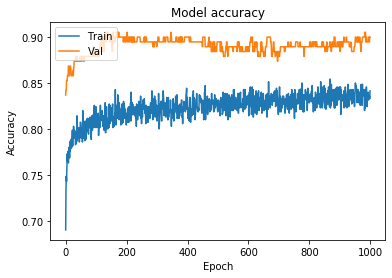

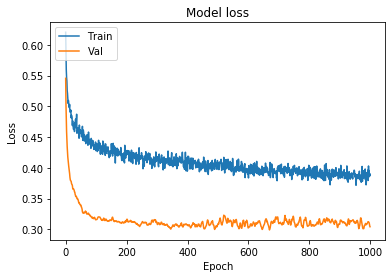

In [30]:
#plotting graphs

#training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### submission data preparation

In [31]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [33]:
#Doing the same preprocessing as above on the submission dataset
data = test
#Handling the cabin row
d = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2}
for i in range(len(data['Cabin'])):
    if type(data['Cabin'][i]) is float:
        data['Cabin'][i] = 1
    else:
        data['Cabin'][i] = d[data['Cabin'][i][0]]
#Handling the embarked row
data.fillna({'Embarked':0})
for i in range(len(data['Embarked'])):
    if data['Embarked'][i] is 'S':
        data['Embarked'][i] = 2
    elif data['Embarked'][i] is 'C':
        data['Embarked'][i] = 3
    else:
        data['Embarked'][i] = 1
#Dropping the Ticket column
data = data.drop(columns='Ticket')
#Handling the Age column
data['Age'].fillna(data['Age'].median(), inplace = True)
#Handling the Sex column
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
#Handling the names of the passengers
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)
data = data.drop(columns='Name')
data = data.drop(columns='PassengerId')
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,1,34.5,0,0,7.8292,1,1,1
1,3,0,47.0,1,0,7.0000,1,2,3
2,2,1,62.0,0,0,9.6875,1,1,1
3,3,1,27.0,0,0,8.6625,1,2,1
4,3,0,22.0,1,1,12.2875,1,2,3


In [35]:
test = data.as_matrix()
test = sc.transform(test)
test.shape

(418, 9)

In [37]:
predictions = np.squeeze(model.predict_classes(test))
PassengerId = np.arange(892, 1310)

### data for submission

In [38]:
#output
output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)